# Augment Heatmaps

Heatmaps are in `imgaug` float32-based image-like 2D arrays. They are constrained to a known value range, usually 0.0 to 1.0. A heatmap may have any number of channels (including none). Heatmaps are represented with the class `imgaug.augmentables.heatmaps.HeatmapsOnImage`. Depending on the context, the term "heatmap" may denote the 2D array, a single channel within that array or an instance of `HeatmapsOnImage`. Heatmaps are commonly used as representations for the ground truth in keypoints/landmark prediction.

To create an instance of `imgaug.augmentables.heatmaps.HeatmapsOnImage`, the following arguments are necessary:
  * `arr`: The raw numpy float32 heatmap array with shape `(H,W)` or `(H,W,C)`.
  * `shape`: The shape of the *image* to which the heatmap belongs (*not* the shape of the heatmap array).
  * `min_value` (optional, default is 0.0): The minimum possible value of the input heatmap array. Heatmaps are internally normalized to the value range 0.0 to 1.0.
  * `max_value` (optional, default is 1.0): Analogous to min_value.

Noteworthy methods of `HeatmapsOnImage` are:
  * `get_arr()`: Returns the heatmap array, unnormalized to the value range `[min_value, max_value]`.
  * `draw([size], [cmap])`: Convert the heatmap to an RGB image.
  * `draw_on_image(image, [alpha], [cmap], [resize])`: Convert the heatmap to an RGB image, overlayed with the image to which it belongs.
  * `invert()`: Transform any value in the heatmap array from `v` to `1.0-v`.
  * `pad([top], [right], [bottom], [left], [mode], [cval])`: Pad the heatmap array.
  * `pad_to_aspect_ratio(aspect_ratio, [mode], [cval], [return_pad_amounts])`: Analogous to `pad()`.
  * `avg_pool([block_size])`: Average pool with given kernel size.
  * `max_pool([block_size])`: Max pool with given kernel size.
  * `resize([sizes], [interpolation])`: Resize the heatmap array to the provided size.

All of the above methods (except for `get_arr()`) operate on arrays normalized to `[0.0, 1.0]`. This e.g. influences sensible values for `cval` in `pad()`.

Instances of `HeatmapsOnImage` are augmented using `augment(images=..., heatmaps=...)` or `augment_heatmaps(<heatmaps>)`, both of which are offered by all augmenters.

For more details, see the [API](https://imgaug.readthedocs.io/en/latest/source/api.html), e.g. [imgaug.augmentables.heatmaps.HeatmapsOnImage](https://imgaug.readthedocs.io/en/latest/source/api_imgaug.html#imgaug.augmentables.heatmaps.HeatmapsOnImage), [imgaug.augmenters.meta.Augmenter.augment()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment) or [imgaug.augmenters.meta.Augmenter.augment_heatmaps()](https://imgaug.readthedocs.io/en/latest/source/api_augmenters_meta.html#imgaug.augmenters.meta.Augmenter.augment_heatmaps).

**Important**: `imgaug`'s heatmap augmentation is geared towards ground truth outputs. As such, only augmentation techniques that change the image geometry will be applied to heatmaps, even when other augmentation techniques are part of a pipeline. Examples for that are e.g. horizontal flips or affine transformations. To also apply non-geometric augmentation techniques, feed the heatmap array through `augment_images()` instead.

## Loading Example Data

Let's take a look at a simple example. We will first load an image with a corresponding heatmap. In this case, we simply query a method in `imgaug` that returns us an example heatmap, but any other float32 array could also be used via `HeatmapsOnImage(<that array>, shape=image.shape)`.

The heatmap that we load here corresponds roughly to a distance map, i.e. objects close to the camera have values close to 0.0 and objects far away have values close to 1.0.

In [1]:
import imgaug as ia
%matplotlib inline

image = ia.quokka(size=0.25)
heatmap = ia.quokka_heatmap(size=0.25)

Our next step is to visualize image and heatmap. We use the method `imgaug.HeatmapsOnImage.draw()` to convert the heatmap to an RGB image. As a heatmap can have multiple channels, `draw()` always returns a list of images, with each image representing the visualization of a single heatmap channel. Here, our heatmap only consists of a single channel and hence we select the first result of `draw()`.

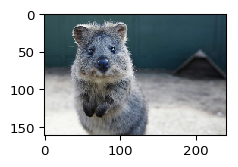

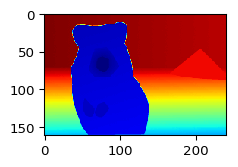

In [2]:
ia.imshow(image)
ia.imshow(heatmap.draw()[0])

So what is exactly the data saved in our heatmap?

In [3]:
import numpy as np
print(type(heatmap))
print(type(heatmap.arr_0to1))  # the numpy heatmap array, normalized to [0.0, 1.0]
print(np.min(heatmap.arr_0to1), np.max(heatmap.arr_0to1))

<class 'imgaug.augmentables.heatmaps.HeatmapsOnImage'>
<class 'numpy.ndarray'>
0.0 1.0


The heatmap is an instance of `imgaug.augmentables.heatmaps.HeatmapsOnImage` (line 1). Internally that class represents the heatmap as a float32 array (line 2), which is always normalized to the value range 0.0 to 1.0 (line 3).

What about the image size and the heatmap size?

In [4]:
print(image.shape, heatmap.arr_0to1.shape)

(161, 240, 3) (161, 240, 1)


So the image and the heatmap array both have a height of 161 pixels and a width of 240 pixels. The heatmap array however could deviate from the image array. `imgaug` would automatically adjust the applied augmentations to the size difference. For example, `Crop` may end up removing less pixels from the heatmap than the image if the heatmap is smaller than the image.

## Augmenting the Example Heatmap

Now that we have our example data loaded, it is time to augment it. We will use a combination of `Dropout` (sets random pixels to zero) and affine transformation (here only rotates the image). The image will be affected by both augmentation techniques, but the heatmap will only be affected by the (geometric) affine transformations.

In [5]:
import imgaug.augmenters as iaa
ia.seed(2)

seq = iaa.Sequential([
    iaa.Dropout(0.2),
    iaa.Affine(rotate=(-45, 45))
])

Now we augment image and heatmap using `seq.augment(...)`, for which `seq(...)` is the shortcut:

In [6]:
image_aug, heatmap_aug = seq(image=image, heatmaps=heatmap)

Note that if we had multiple images, we would have used `images=...` instead of `image=...` (and also a list of heatmaps instead of a single one). The method does not require the `heatmap` input to be an instance of `HeatmapsOnImage` (or a list of it). A float numpy array would also be accepted (or a list of such arrays, one per image).

Now let's take a look at the results. We visualize the original image (left), the heatmap (middle) and a blend between image and heatmap (right).

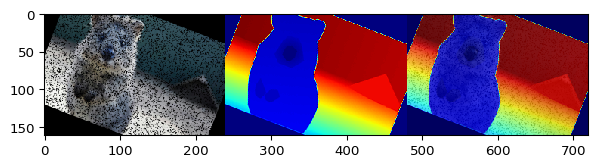

In [7]:
ia.imshow(
    np.hstack([
        image_aug,
        heatmap_aug.draw()[0],
        heatmap_aug.draw_on_image(image_aug)[0]
    ]))

As expected, the rotation of the image and the heatmap align. Note also how the heatmap is not affected by `Dropout`.

We used `draw()[0]` instead of `draw()`, because the method returns a list, containing one RGB image per channel in the heatmap.

## Augment a Heatmap with Lower Resolution than the Image

As mentioned before, `imgaug` supports heatmaps that have a height/width that differs from the corresponding image's height/width. This is often desirable, e.g. to train a network with high resolution images as input and coarser heatmaps outputs. In the following example, we will test a heatmap that has lower resolution than the image.

Let's take our example heatmap again, but resize it to a quarter of the original size using `resize()`:

Original heatmap size: (161, 240, 1)
Resized heatmap size: (40, 60, 1)
Image size: (161, 240, 3)


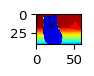

In [8]:
heatmap_smaller = heatmap.resize(0.25)
print("Original heatmap size:", heatmap.arr_0to1.shape)
print("Resized heatmap size:", heatmap_smaller.arr_0to1.shape)
print("Image size:", image.shape)
ia.imshow(heatmap_smaller.draw()[0])

As you can see, the unaugmented heatmap array now has a height of 40 pixels and a width of 60 pixels, down from 161 and 240.

We now augment it using the same augmentation pipeline (affine transformation + dropout) again:

In [9]:
image_aug, heatmap_smaller_aug = seq(image=image, heatmaps=heatmap_smaller)

Now we can visualize it in the same way as before:

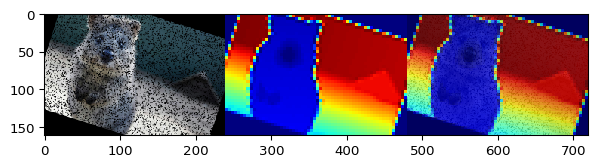

In [10]:
ia.imshow(np.hstack([
    image_aug,
    heatmap_smaller_aug.draw(size=image_aug.shape[0:2])[0],
    heatmap_smaller_aug.draw_on_image(image_aug)[0]
]))

## Create a Heatmap from a Numpy Array

Previously, we have created heatmaps by simply querying an example function, which returned already instantiated `HeatmapsOnImage` instances. Let's now manually create a `HeatmapsOnImage` instance from a numpy array instead. In the following example we generate a horizontal gradient from 0.0 to 1.0, i.e. a heatmap that has values close to 0.0 on the left side of the image and values close to 1.0 on the right side.

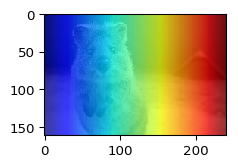

In [11]:
from imgaug.augmentables.heatmaps import HeatmapsOnImage
arr = np.linspace(0, 1.0, num=128).astype(np.float32)  # (128,)
arr = arr.reshape((1, 128))  # (1, 128)
arr = np.tile(arr, (128, 1))  # (128, 128)
heatmap = HeatmapsOnImage(arr, shape=image.shape)
ia.imshow(heatmap.draw_on_image(image)[0])

## Create a Multi-Channel Heatmap from a Numpy Array

Up to this point we have only worked with single-channel heatmaps. We extend now the previous example by creating a heatmap with four channels instead. We use the same horizontal gradient for the first channel. In the second and third channel, we start with the horizontal gradient and decrease its values within different rectangular subareas. In the fourth channel, we start with the horizontal gradient and set regularly spaced heatmap pixels to zero.

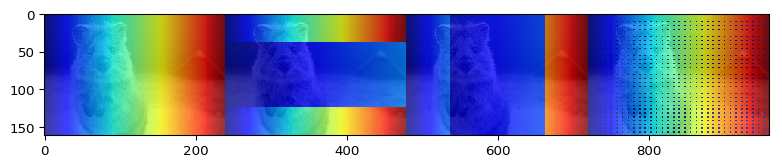

In [12]:
# first channel, horizontal gradient
arr0 = np.linspace(0, 1.0, num=128).astype(np.float32)  # (128,)
arr0 = arr0.reshape((1, 128))  # (1, 128)
arr0 = np.tile(arr0, (128, 1))  # (128, 128)

# second channel, set horizontal subarea to low value
arr1 = np.copy(arr0)
arr1[30:-30, :] *= 0.25

# third channel, set vertical subarea to low value
arr2 = np.copy(arr0)
arr2[:, 30:-30] *= 0.25

# fourth channel, set pixels in regular distances to zero
arr3 = np.copy(arr0)
arr3[::4, ::4] = 0

# create heatmap array and heatmap
arr = np.dstack([arr0, arr1, arr2, arr3])  # (128, 128, 4)
heatmaps = HeatmapsOnImage(arr, shape=image.shape)

# visualize
heatmaps_drawn = heatmaps.draw_on_image(image)
ia.imshow(np.hstack([
    heatmaps_drawn[0],  # arr0 as heatmap drawn on the image
    heatmaps_drawn[1],  # arr1 as heatmap drawn on the image
    heatmaps_drawn[2],  # arr2 as heatmap drawn on the image
    heatmaps_drawn[3]   # arr3 as heatmap drawn on the image
]))

## Resize, Average Pool and Max Pool Heatmaps

We have already used `resize()` in one of the earlier examples to alter the size of heatmaps. We will now test two alternative methods, `avg_pool()` and `max_pool()`, that can be used in similar ways. As their names indicate, the methods perform average pooling and max pooling. `max_pool()` is a function that should be considered when working with heatmaps that are much smaller than the input image size and that have sparse activations (i.e. few values above zero). In these cases, resizing could lead to little remaining activation, while max pooling guarantees that the maximum of a group of cells "survives".

The example below showcases the three different methods. They are fairly similar to each other, though note that while `resize()` accepts a fraction as its argument (e.g. `0.25` to scale to `25%` of the original image size), the two pooling methods expect a kernel size (e.g. `4` to scale to `25%` of the original image size).

[shapes] resized: (40, 60, 1), avg pooled: (41, 60, 1), max pooled: (41, 60, 1)


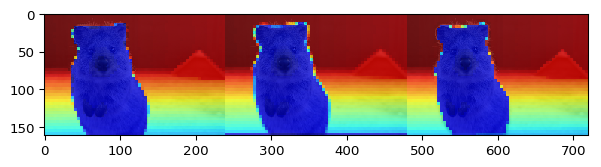

[shapes] resized: (20, 30, 1), avg pooled: (21, 30, 1), max pooled: (21, 30, 1)


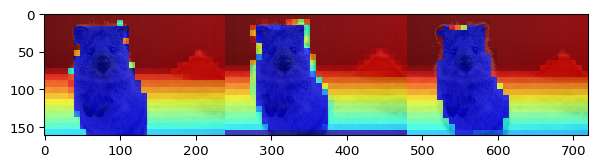

[shapes] resized: (10, 15, 1), avg pooled: (11, 15, 1), max pooled: (11, 15, 1)


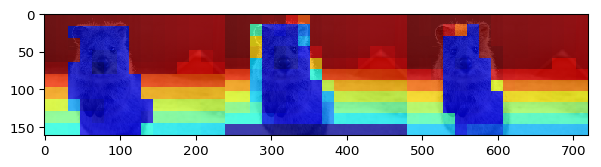

In [13]:
# reload the example heatmap, since we replaced it in the previous example
heatmap = ia.quokka_heatmap(size=0.25)

# test with 1/4th, 1/8th and 1/16th of the original image size
for factor in [4, 8, 16]:
    # resize/pool
    heatmap_resized = heatmap.resize(1/factor)
    heatmap_avg_pooled = heatmap.avg_pool(factor)
    heatmap_max_pooled = heatmap.max_pool(factor)

    # print heatmap sizes after resize/pool
    print("[shapes] resized: %s, avg pooled: %s, max pooled: %s" % (
        heatmap_resized.get_arr().shape,
        heatmap_avg_pooled.get_arr().shape,
        heatmap_max_pooled.get_arr().shape
    ))
    
    # visualize
    ia.imshow(
        np.hstack([
            heatmap_resized.draw_on_image(image)[0],
            heatmap_avg_pooled.draw_on_image(image)[0],
            heatmap_max_pooled.draw_on_image(image)[0]
        ])
    )

## Customize Drawing

We have used `draw()` and `draw_on_image()` quite a lot above. `draw()` generates an RGB image of the heatmap, while `draw_on_image()` additionally blends it with an existing image. The following section takes a deeper look at the arguments of both methods.

While `draw_on_image()` always generates outputs either at the heatmap size or the image size, `draw()` defaults to the heatmap size and can optionally be requested to produce any other size. The below example uses the default value, a fraction and an explicit `(height, width)` amount.

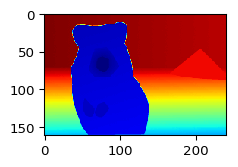

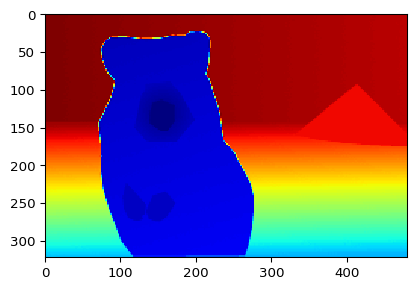

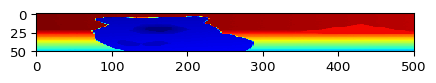

In [14]:
ia.imshow(heatmap.draw()[0])
ia.imshow(heatmap.draw(size=2.0)[0])
ia.imshow(heatmap.draw(size=(50, 500))[0])

Both `draw()` and `draw_on_image()` have a `cmap` argument that can be set to any matplotlib colormap. The default value is `jet`. The below example visualizes three other colormaps:

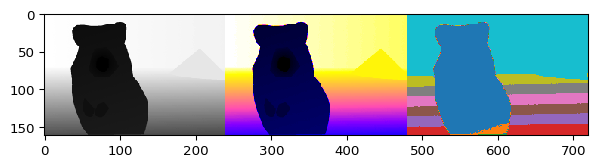

In [15]:
ia.imshow(
    np.hstack([
        heatmap.draw(cmap="gray")[0],
        heatmap.draw(cmap="gnuplot2")[0],
        heatmap.draw(cmap="tab10")[0]
    ])
)

The same for `draw_on_image()`:

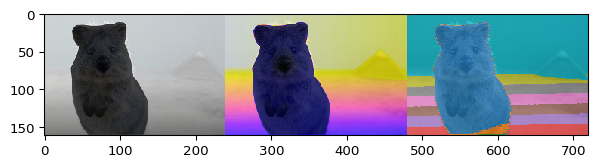

In [16]:
ia.imshow(
    np.hstack([
        heatmap.draw_on_image(image, cmap="gray")[0],
        heatmap.draw_on_image(image, cmap="gnuplot2")[0],
        heatmap.draw_on_image(image, cmap="tab10")[0]
    ])
)

`draw_on_image()` blends the heatmap visualization generated by `draw()` with the original image. The opacity of the blending can be configured using the `alpha` argument:

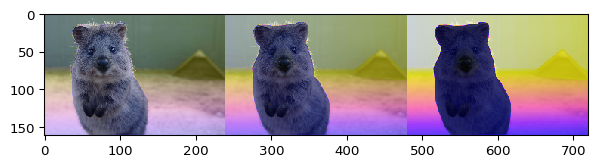

In [17]:
ia.imshow(
    np.hstack([
        heatmap.draw_on_image(image, cmap="gnuplot2", alpha=0.25)[0],
        heatmap.draw_on_image(image, cmap="gnuplot2", alpha=0.50)[0],
        heatmap.draw_on_image(image, cmap="gnuplot2", alpha=0.75)[0]
    ])
)

By default, `draw_on_image()` will resize a heatmap to the image size if the heatmap has a different size than the image. (The interpolation used for the resizing is nearest neighbour interpolation.) Sometimes it can be more appropriate to resize the image instead of the heatmap. This is done by simply adding `resize="image"` to the call:

Heatmap only:


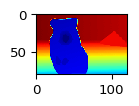

Heatmap upscaled to image size:


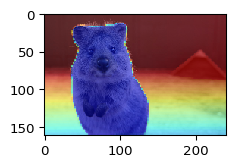

Image downscaled to heatmap size:


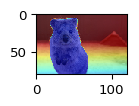

In [18]:
heatmap_small = heatmap.resize(0.5)

print("Heatmap only:")
ia.imshow(heatmap_small.draw()[0])

print("Heatmap upscaled to image size:")
ia.imshow(heatmap_small.draw_on_image(image, resize="heatmaps", alpha=0.5)[0])

print("Image downscaled to heatmap size:")
ia.imshow(heatmap_small.draw_on_image(image, resize="image", alpha=0.5)[0])

## Invert Heatmaps

Heatmaps can easily be inverted using `invert()` to change each pixel $I_{i,j}$ to $1.0 - I_{i,j}$.

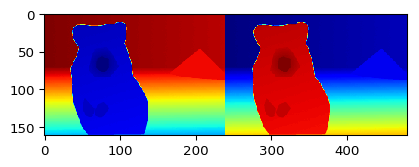

In [19]:
ia.imshow(
    np.hstack([
        heatmap.draw()[0],
        heatmap.invert().draw()[0]
    ])
)

## Pad Heatmaps

When padding images, it is usually sensible to also pad the corresponding heatmap. That is done using `HeatmapsOnImage.pad()` and `HeatmapsOnImage.pad_to_aspect_ratio()`. Both support various padding modes, similar to `numpy.pad()`. The below example pads a heatmap using `HeatmapsOnImage.pad()` with pad modes `constant` (fill all new pixels with a constant value), `edge` (fill all new pixels with the value of the closest edge) and `maximum` (fill all new pixels with the maximum of the axis).

Original:


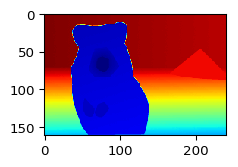

Padded with (left) mode=constant, (middle) mode=edge, (right) mode=maximum:


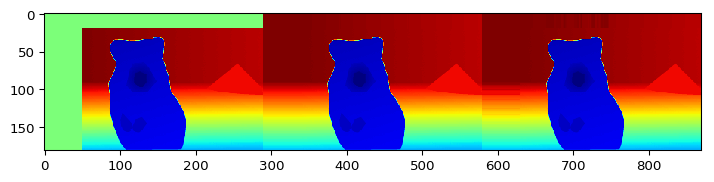

In [20]:
print("Original:")
ia.imshow(heatmap.draw()[0])

print("Padded with (left) mode=constant, (middle) mode=edge, (right) mode=maximum:")
ia.imshow(
    np.hstack([
        heatmap.pad(top=20, left=50, mode="constant", cval=0.5).draw()[0],
        heatmap.pad(top=20, left=50, mode="edge").draw()[0],
        heatmap.pad(top=20, left=50, mode="maximum").draw()[0]
    ])
)

The method `pad_to_aspect_ratio()` has very similar argument, but expects a `width/height` ratio instead of pixel amounts to pad per side.

Aspect ratio = 1.0:


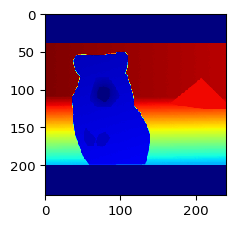

Aspect ratio = 4.0:


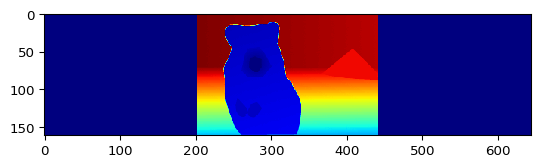

In [21]:
print("Aspect ratio = 1.0:")
ia.imshow(heatmap.pad_to_aspect_ratio(1.0, mode="constant", cval=0).draw()[0])

print("Aspect ratio = 4.0:")
ia.imshow(heatmap.pad_to_aspect_ratio(4.0, mode="constant", cval=0).draw()[0])

Note that both padding methods pad in `[0.0, 1.0]` space, even when the original input array used a different value range. Hence, if a `cval` is used, it needs to also be within `[0.0, 1.0]` value range.

## Create a Heatmap from an Array with Value Range outside of 0.0 to 1.0

We have seen further above how to create a `HeatmapsOnImage` instance from a numpy array with values in the range 0.0 to 1.0. The class constructor however also accepts arrays with value ranges beyond that constraint. The only condition is that the value range is explicitly defined via `HeatmapsOnImage(..., min_value=<minimum>, max_value=<maximum>)`. `HeatmapsOnImage` will then internally convert the heatmap to `[0.0, 1.0]` and unnormalize whenever `get_arr()` is called.

heatmap_arr min/max:       -1.0 20.0
heatmap.arr_0to1 min/max:  0.0 1.0
heatmap.get_arr() min/max: -1.0 20.0


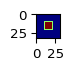

In [22]:
# A simple squared heatmap with values outside the range [0.0, 1.0]
heatmap_arr = np.zeros((32, 32), dtype=np.float32)
heatmap_arr[:-10, :] = -1.0
heatmap_arr[-10:, :] = -1.0
heatmap_arr[10:-10, 10:-10] = 10.0
heatmap_arr[12:-12, 12:-12] = 20.0
print("heatmap_arr min/max:      ", np.min(heatmap_arr), np.max(heatmap_arr))

# Create a heatmap instance from the array
heatmap = HeatmapsOnImage(heatmap_arr, min_value=-1.0, max_value=20.0, shape=(32, 32, 3))

# Show min and max values.
# Note that arr_0to1 is the internal representation and normalized to [0.0, 1.0],
# while the array returned by get_arr() is not normalized.
print("heatmap.arr_0to1 min/max: ", np.min(heatmap.arr_0to1), np.max(heatmap.arr_0to1))
print("heatmap.get_arr() min/max:", np.min(heatmap.get_arr()), np.max(heatmap.get_arr()))

ia.imshow(heatmap.draw()[0])

As the array values are projected to `[0.0, 1.0]` in float32, the minimum and maximum values should not be picked arbitrarily low/high, as that could cause numeric issues related to the limited accuracy of float32.